# Single neuron Calcium Imaging

This notebook has the code to extract Calcium traces from the single neuron recordings on ZIM01.

In [2]:
#Unet
#import pckgs
import cv2
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import re

import os
from natsort import natsorted
from imutils.src import imfunctions

Using TensorFlow backend.


### Do max projection on your hyperstack (See Hyperstack_tests notebook)

In [ ]:
hyperstack_path='/scratch/zimmer/DanielM/hyperstack/2021-07-01_15-08-56_worm3_on-channel-1-pco_camera2.btf'

hyperstack=tiff.memmap(hyperstack_path, dtype='uint16')


print(hyperstack.shape)



In [ ]:
output_filepath='/scratch/zimmer/DanielM/hyperstack/2021-07-01_15-08-56_worm3_on-channel-1-pco_camera2_MAX.btf'
with tiff.TiffWriter(output_filepath, bigtiff=True) as tif_writer:
    for volume in hyperstack:
#         print(volume.shape)
#         print(type(volume))
        volume_projection = np.max(volume, axis=0)
#         print(volume_projection.shape)
#         print(type(volume_projection))
        tif_writer.write(volume_projection, contiguous=True)
        #break

### Option 1: Binarize using make_contour based binary

In [ ]:
input_filepath='/scratch/zimmer/DanielM/hyperstack/2021-07-01_15-08-56_worm3_on-channel-0-pco_camera1_MAX.btf'
output_filepath='/scratch/zimmer/DanielM/hyperstack/2021-07-01_15-08-56_worm3_on-channel-0-pco_camera1bigtiff_binary_cs_500_lt140_TEST.btf'
median_blur=3
lt=140
ht=255
contour_size=500
tolerance=0.5
area_to_fill=100
imfunctions.make_contour_based_binary(input_filepath, output_filepath, median_blur, lt, ht, contour_size, tolerance, area_to_fill)


In [ ]:
#To check what areas the contour size and tolerance parameters give:
contour_size=500
tolerance=0.5
print(contour_size*(1-tolerance))
print(contour_size*(1+tolerance))

### Option 2: Binarize only with blur and threshold

In [ ]:
input_filepath='/scratch/zimmer/DanielM/hyperstack/2021-07-01_15-08-56_worm3_on-channel-0-pco_camera1_MAX.btf'
output_filepath='/scratch/zimmer/DanielM/hyperstack/2021-07-01_15-08-56_worm3_on-channel-0-pco_camera1bigtiff_binary_blur3_lt140.btf'
median_blur=3
lt=140
ht=255


with tiff.TiffWriter(output_filepath, bigtiff=True) as tif_writer:
    with tiff.TiffFile(input_filepath, multifile=False) as tif:
        for i, page in enumerate(tif.pages):
            #loads the first frame and inverts it
            img=page.asarray()
            #median Blur
            if median_blur!=0:
                img=cv2.medianBlur(img,median_blur)

            #apply threshold
            ret, new_img = cv2.threshold(img,lt,ht,cv2.THRESH_BINARY)
            tif_writer.write(new_img,contiguous=True)

### Transform GCAMP Channel if needed
This will transform the GCAMP Channel in case the camera alignment was not good.

In [ ]:
gcamp_filepath='/scratch/zimmer/DanielM/hyperstack/2021-07-01_15-08-56_worm3_on-channel-1-pco_camera2_MAX.btf'
output_filepath='/scratch/zimmer/DanielM/hyperstack/2021-07-01_15-08-56_worm3_on-channel-1-pco_camera2_MAX_corrected.btf'
with tiff.TiffWriter(output_filepath, bigtiff=True) as tif_writer,\
    tiff.TiffFile(gcamp_filepath, multifile=False) as tif_gcamp:
    for i, page in enumerate(tif_gcamp.pages):
        img=page.asarray()
        #create the transformation matrix 
        M = np.float32([[1, 0, -22], [0, 1, 0]])
        #transform it based on the transformation matrix
        shifted = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
        #flip if needed
        flipped = cv2.flip(shifted, 1)
        #save the processed Gcamp channel
        tif_writer.write(flipped, contiguous=True)

### background removal

The background has to be removed!
From the single planes the background is 100 in the red as well as the green channel.

From the MAX projection it is 104.

I am not sure whether it is good to substract it from already max projected or it should be removed for the single plane and then do MAX projection. I should test this

In [88]:
rfp_mask_filepath='/scratch/zimmer/DanielM/hyperstack/2021-07-01_15-08-56_worm3_on-channel-0-pco_camera1bigtiff_binary_cs_500_lt140.btf'
gcamp_filepath='/scratch/zimmer/DanielM/hyperstack/2021-07-01_15-08-56_worm3_on-channel-1-pco_camera2_MAX_corrected.btf'
rfp_filepath='/scratch/zimmer/DanielM/hyperstack/2021-07-01_15-08-56_worm3_on-channel-0-pco_camera1_MAX.btf'

gcamp_signal=[]
rfp_signal=[]


with tiff.TiffFile(rfp_mask_filepath, multifile=True) as tif_mask,\
    tiff.TiffFile(gcamp_filepath, multifile=False) as tif_gcamp,\
    tiff.TiffFile(rfp_filepath, multifile=False) as tif_rfp:
    for i, page in enumerate(tif_mask.pages):
        mask=page.asarray()
        gcamp=tif_gcamp.pages[i].asarray()
        rfp=tif_rfp.pages[i].asarray()
        
        #find where the mask is
        roi=np.where(mask==255)
        
        gcamp_roi_signal=np.mean(gcamp[roi])
        rfp_roi_signal=np.mean(rfp[roi])
                   
        #append
        gcamp_signal.append(gcamp_roi_signal)
        rfp_signal.append(rfp_roi_signal)

#optional plotting
#         fig, axes=plt.subplots(ncols=3, nrows=2, dpi=200)
#         axes[0,0].imshow(mask)
#         axes[0,0].set_title('mask')
#         axes[0,1].imshow(gcamp)
#         axes[0,1].set_title('gcamp')
#         axes[0,2].imshow(rfp)
#         axes[0,2].set_title('rfp')
#         axes[1,1].imshow(gcamp_masked)
#         axes[1,2].imshow(rfp_masked)
#         if i>10: break

/users/ulises.rey/anaconda3/envs/openCV/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/users/ulises.rey/anaconda3/envs/openCV/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


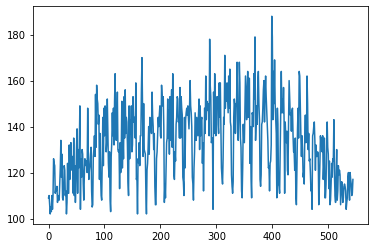

In [89]:
plt.plot(gcamp[roi])

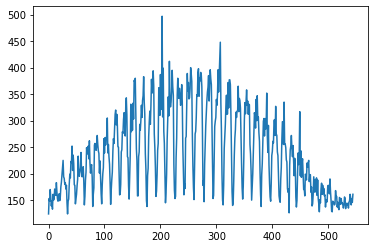

In [90]:
plt.plot(rfp[roi])

In [91]:
#convert list to numpy array
gcamp_signal=np.array(gcamp_signal)
rfp_signal=np.array(rfp_signal)


In [92]:
#remove background (TODO: improve background calculation)
gcamp_signal=gcamp_signal-104
rfp_signal=rfp_signal-104

Text(0.5, 0, 'Time (acquisition volumes)')

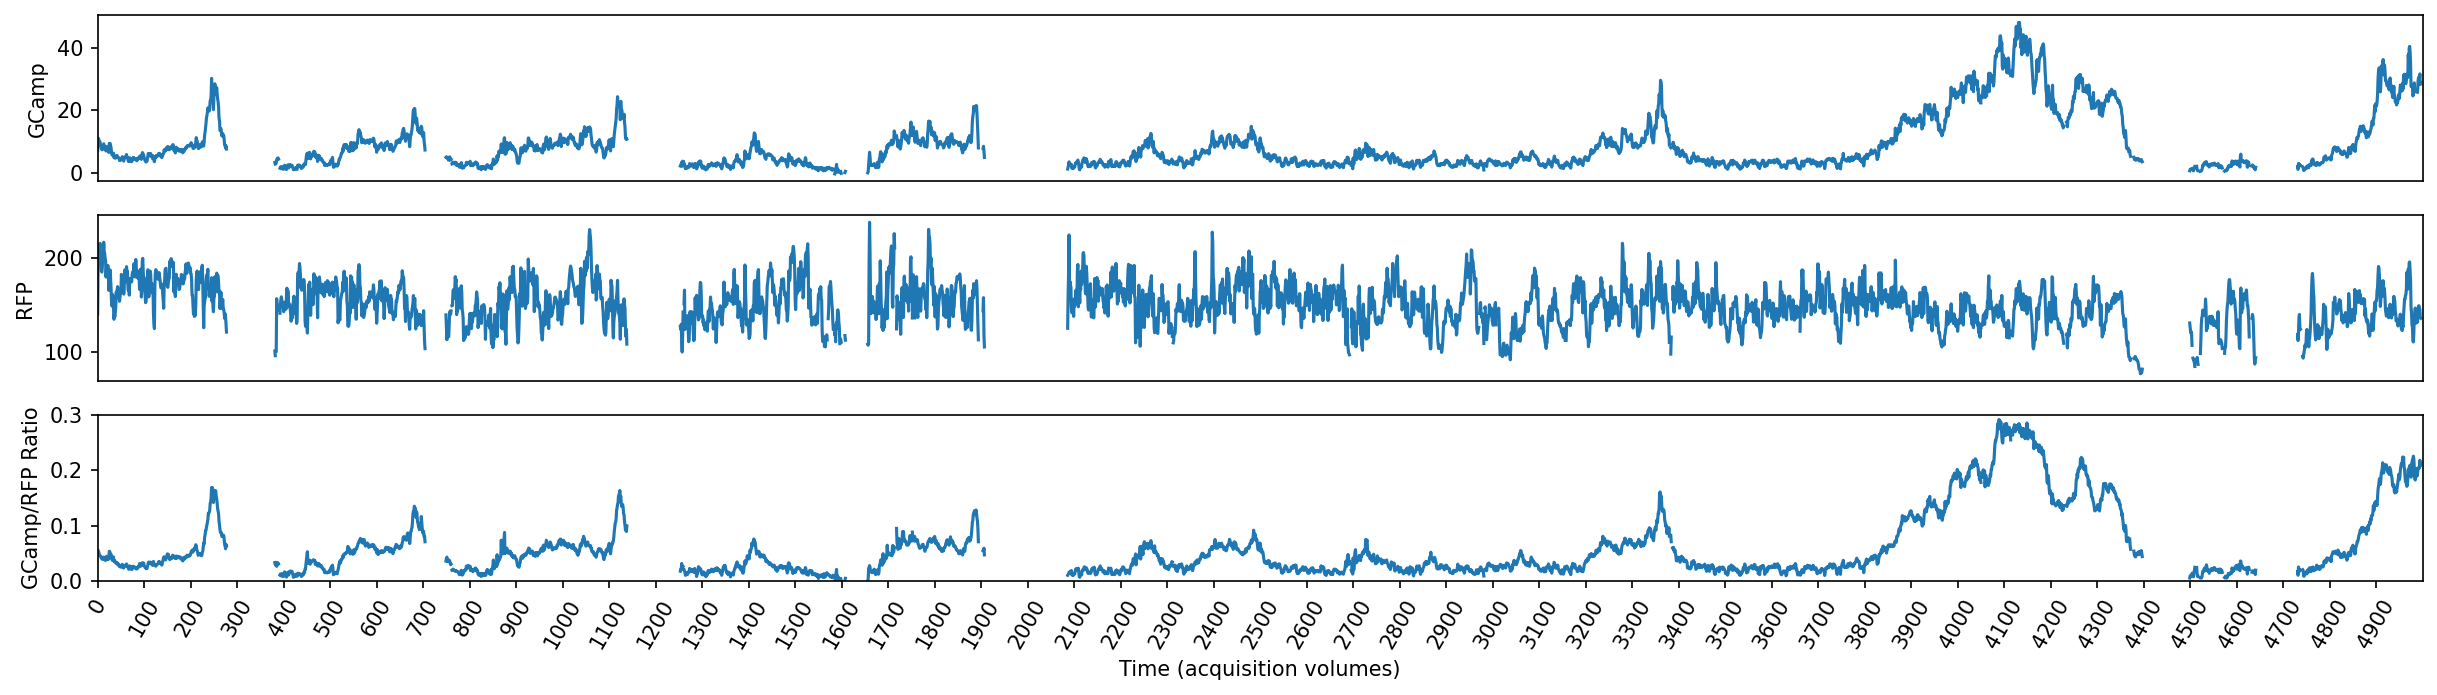

In [85]:
fig, axes=plt.subplots(figsize=(20,5),nrows=3, dpi=150)
axes[0].plot(gcamp_signal)
axes[0].set_ylabel('GCamp')
axes[1].plot(rfp_signal)
axes[1].set_ylabel('RFP')
axes[2].plot(gcamp_signal/rfp_signal)
axes[2].set_ylabel('GCamp/RFP Ratio')

for i,ax in enumerate(axes):
    ax.set_xlim([0, 5000])
    if i<2:
        ax.set_xticks([])

    if i==2:
        ax.set_xticks(np.arange(0, 5000,100))
        ax.tick_params(axis='x', labelrotation = 60)

axes[2].set_ylim([0, 0.3])
axes[2].set_xlabel('Time (acquisition volumes)')

In [ ]:
#find frames where there is no signal
np.where(np.isnan(gcamp_signal))

In [ ]:
#check % of frames without signal
np.isnan(gcamp_signal).sum()/gcamp_signal.shape[0]

### Stack Subsampling

For instance the behaviour to have same number of frames as max projections (default is number of frames == total number of planes)

In [ ]:
input_filepath='/scratch/zimmer/DanielM/BAG_Gcamp_07_01/btf_all/bh/2021-07-01_15-10-32_worm3_on-channel-0-behaviour-bigtiff.btf'
output_filepath='/scratch/zimmer/DanielM/hyperstack/2021-07-01_15-10-32_worm3_on-channel-0-behaviour-bigtiff_subsampled.btf'
with tiff.TiffFile(input_filepath, multifile=False) as tif,\
 tiff.TiffWriter(output_filepath, bigtiff=True) as tif_writer:
    for i, page in enumerate(tif.pages):
        if i %20==0:
            img=page.asarray()
            tif_writer.write(img,contiguous=True)
            